# spacetrackのテスト その2

ダウンロードしたデータをいろいろプロットしてみる

JSONやCSV形式では、TLEから以下の項目が追加される。
- OBJECT_ID : INTLDES のフォーマットを整えたもの
- OBJECT_NUMBER : NORAD_CAT_IDと基本的に同じ (INTLDESが振られていないものは、OBJECT_NUMBERも振られていない)
- SEMIMAJOR_AXIS (a) = (mu/(n\*2\*pi/(24\*3600))^2)^(1/3)  # mu = 398600.4418 地球の重力
- PERIOD = 1440/n
- APOGEE = (a * (1 + e)) - 6378.135 # 地球は完全な球体だと仮定している
- PERIGEE = (a * (1 - e)) - 6378.135
- DECAYED : Predicted and historical decay information. 

In [1]:
import spacetrack.operators as op
from spacetrack import SpaceTrackClient
from sgp4.earth_gravity import wgs84
from sgp4.io import twoline2rv
from datetime import datetime
import numpy as np
import pandas as pd
import time
import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 80)

In [3]:
# userid and password are set in here
import spacetrackaccount
# print("Login with " + spacetrackaccount.userid)

In [4]:
st = SpaceTrackClient(spacetrackaccount.userid, spacetrackaccount.password)

In [5]:
def mycallback(until):
    duration = int(round(until - time.monotonic()))
    print('Sleeping for {:d} seconds.'.format(duration))

st.callback = mycallback

In [6]:
# 全衛星の最新データ(30日以内)をcsvで取得
data = st.tle_latest(ordinal=1, epoch='>now-30', orderby='norad_cat_id', format='csv')

In [7]:
with open('download/tle_latest.csv', 'w') as fp:
        fp.write(data)

In [8]:
df = pd.read_csv('download/tle_latest.csv')

In [9]:
df.head(3)

,ORDINAL,COMMENT,ORIGINATOR,NORAD_CAT_ID,OBJECT_NAME,OBJECT_TYPE,CLASSIFICATION_TYPE,INTLDES,EPOCH,EPOCH_MICROSECONDS,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,FILE,TLE_LINE0,TLE_LINE1,TLE_LINE2,OBJECT_ID,OBJECT_NUMBER,SEMIMAJOR_AXIS,PERIOD,APOGEE,PERIGEE,DECAYED
0,1,GENERATED VIA SPACETRACK.ORG API,18 SPCS,5,VANGUARD 1,PAYLOAD,U,58002B,2020-11-01 03:54:24,992928,10.848689,0.184703,34.2554,167.1112,247.5923,91.9235,0,999,22019,-0.000017,6.000000e-08,0.0,2867629,0 VANGUARD 1,1 5U 58002B 20306.16278927 .00000006 00000-0 -17295-4 0 9998,2 5 34.2554 167.1112 1847025 247.5923 91.9235 10.84868903220198,1958-002B,5.0,8619.531,132.734,3833.445,649.347,0.0
1,1,GENERATED VIA SPACETRACK.ORG API,18 SPCS,11,VANGUARD 2,PAYLOAD,U,59001A,2020-10-31 20:41:59,34912,11.856841,0.146684,32.8758,263.2526,301.5241,45.0175,0,999,29117,0.000102,2.180000e-06,0.0,2867442,0 VANGUARD 2,1 11U 59001A 20305.86248883 +.00000218 +00000-0 +10222-3 0 9995,2 11 032.8758 263.2526 1466840 301.5241 045.0175 11.85684099291171,1959-001A,11.0,8123.736,121.448,2937.224,553.979,0.0
2,1,GENERATED VIA SPACETRACK.ORG API,18 SPCS,12,VANGUARD R/B,ROCKET BODY,U,59001B,2020-10-31 21:38:43,514592,11.443453,0.166636,32.8977,233.5810,73.3135,304.3194,0,999,29561,0.000225,3.680000e-06,0.0,2867442,0 VANGUARD R/B,1 12U 59001B 20305.90189253 +.00000368 +00000-0 +22479-3 0 9999,2 12 032.8977 233.5810 1666365 073.3135 304.3194 11.44345307295617,1959-001B,12.0,8318.220,125.836,3326.205,553.966,0.0


In [10]:
# OBJECT_NUMBER と DECAYED が float となっている (欠損値NaNを含むため)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20015 entries, 0 to 20014
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ORDINAL              20015 non-null  int64  
 1   COMMENT              20015 non-null  object 
 2   ORIGINATOR           20015 non-null  object 
 3   NORAD_CAT_ID         20015 non-null  int64  
 4   OBJECT_NAME          20015 non-null  object 
 5   OBJECT_TYPE          20015 non-null  object 
 6   CLASSIFICATION_TYPE  20015 non-null  object 
 7   INTLDES              19541 non-null  object 
 8   EPOCH                20015 non-null  object 
 9   EPOCH_MICROSECONDS   20015 non-null  int64  
 10  MEAN_MOTION          20015 non-null  float64
 11  ECCENTRICITY         20015 non-null  float64
 12  INCLINATION          20015 non-null  float64
 13  RA_OF_ASC_NODE       20015 non-null  float64
 14  ARG_OF_PERICENTER    20015 non-null  float64
 15  MEAN_ANOMALY         20015 non-null 

In [11]:
# OBJECT_TYPE は 4種類の値を取る
df.query('OBJECT_TYPE != "PAYLOAD" and OBJECT_TYPE != "ROCKET BODY" and OBJECT_TYPE != "DEBRIS" and OBJECT_TYPE != "TBA"')

,ORDINAL,COMMENT,ORIGINATOR,NORAD_CAT_ID,OBJECT_NAME,OBJECT_TYPE,CLASSIFICATION_TYPE,INTLDES,EPOCH,EPOCH_MICROSECONDS,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,FILE,TLE_LINE0,TLE_LINE1,TLE_LINE2,OBJECT_ID,OBJECT_NUMBER,SEMIMAJOR_AXIS,PERIOD,APOGEE,PERIGEE,DECAYED


In [12]:
# TLE文字列も含まれている
df[['TLE_LINE0', 'TLE_LINE1', 'TLE_LINE2']][0:1]

,TLE_LINE0,TLE_LINE1,TLE_LINE2
0,0 VANGUARD 1,1 5U 58002B 20306.16278927 .00000006 00000-0 -17295-4 0 9998,2 5 34.2554 167.1112 1847025 247.5923 91.9235 10.84868903220198


In [13]:
# 衛星の位置・速度を計算する
sat = twoline2rv(df['TLE_LINE1'][0], df['TLE_LINE2'][0], wgs84)
ut = datetime.utcnow()
print(ut)
sat_position, sat_velocity = sat.propagate(ut.year, ut.month, ut.day, ut.hour, ut.minute, ut.second)
sat_position, sat_velocity

2020-11-01 12:57:13.780867


((-9171.96327213994, -1661.5012211492215, 2612.7981271231815),
 (0.9372365898537925, -5.023126365679339, 3.164823061726213))

In [14]:
# 3次元プロットするために、現在時刻の座標を求める
x = []
y = []
z = []
c = []
colors = {'PAYLOAD': 'green', 'ROCKET BODY': 'blue', 'DEBRIS': 'red', 'TBA' : 'black'}
ut = datetime.utcnow()
print(ut)
for line1, line2, object_type in zip(df['TLE_LINE1'], df['TLE_LINE2'], df['OBJECT_TYPE']):
    sat = twoline2rv(line1, line2, wgs84)
    sat_position, sat_velocity = sat.propagate(ut.year, ut.month, ut.day, ut.hour, ut.minute, ut.second)
    x.append(sat_position[0])
    y.append(sat_position[1])
    z.append(sat_position[2])
    c.append(colors[object_type])

2020-11-01 12:57:13.788488


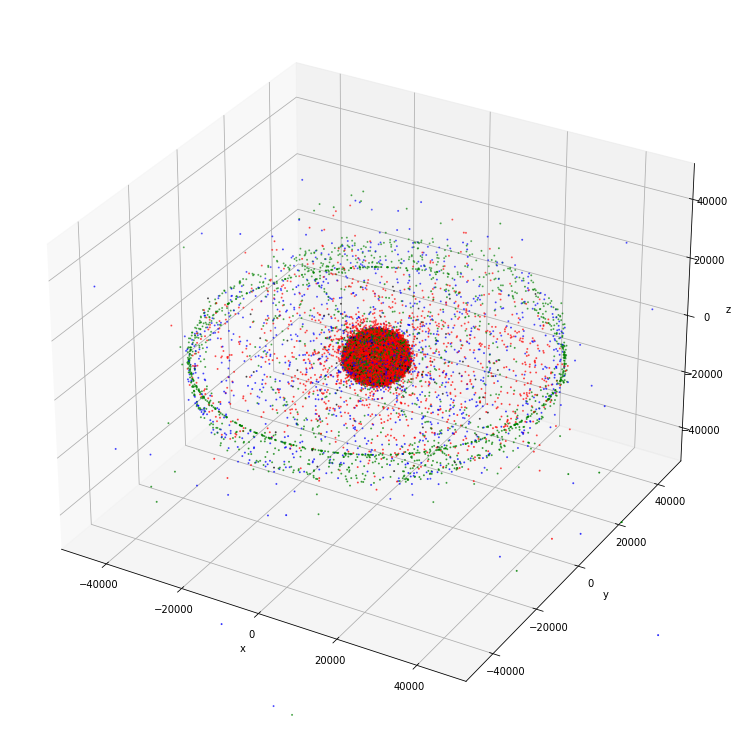

In [15]:
#%matplotlib notebook
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_xlim(-50000, 50000)
ax.set_ylim(-50000, 50000)
ax.set_zlim(-50000, 50000)
ax.scatter3D(x, y, z, c = c, marker = "o", s = 1)
plt.show()

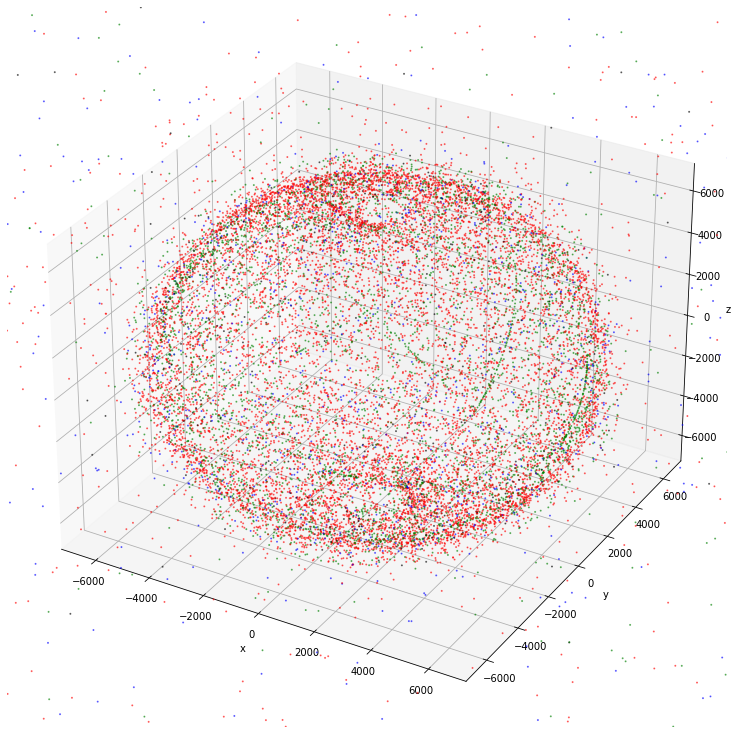

In [16]:
#%matplotlib notebook
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_xlim(-7000, 7000)
ax.set_ylim(-7000, 7000)
ax.set_zlim(-7000, 7000)
ax.scatter3D(x, y, z, c = c, marker = "o", s = 1)
plt.show()

In [17]:
# ISSの過去の全データをcsv形式でダウンロード
data2 = st.tle(norad_cat_id=25544, orderby='epoch', format='csv')

In [18]:
with open('download/tle_25544_all.csv', 'w') as fp:
    fp.write(data2)

In [19]:
df2 = pd.read_csv('download/tle_25544_all.csv')
df2['EPOCH2'] = pd.to_datetime(df2['EPOCH']) # Timestamp型に変換する
df2.head()

,COMMENT,ORIGINATOR,NORAD_CAT_ID,OBJECT_NAME,OBJECT_TYPE,CLASSIFICATION_TYPE,INTLDES,EPOCH,EPOCH_MICROSECONDS,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,FILE,TLE_LINE0,TLE_LINE1,TLE_LINE2,OBJECT_ID,OBJECT_NUMBER,SEMIMAJOR_AXIS,PERIOD,APOGEE,PERIGEE,DECAYED,EPOCH2
0,GENERATED VIA SPACETRACK.ORG API,18 SPCS,25544,ISS (ZARYA),PAYLOAD,U,98067A,1998-11-20 06:49:59,999807,16.050648,0.012536,51.5908,168.3788,86.4185,359.7454,0,999,0,0.000000,-0.000037,0.000012,35498,0 ISS (ZARYA),1 25544U 98067A 98324.28472222 -.00003657 11563-4 00000+0 0 9996,2 25544 051.5908 168.3788 0125362 086.4185 359.7454 16.05064833 05,1998-067A,25544,6638.557,89.716,343.644,177.200,0,1998-11-20 06:49:59
1,GENERATED VIA SPACETRACK.ORG API,18 SPCS,25544,ISS (ZARYA),PAYLOAD,U,98067A,1998-11-20 07:58:35,72831,16.049718,0.012341,51.6173,168.1099,88.0187,273.4932,0,999,1,0.005735,0.118396,0.000012,35498,0 ISS (ZARYA),1 25544U 98067A 98324.33235038 .11839616 11568-4 57349-2 0 9993,2 25544 051.6173 168.1099 0123410 088.0187 273.4932 16.04971811 11,1998-067A,25544,6638.814,89.721,342.608,178.749,0,1998-11-20 07:58:35
2,GENERATED VIA SPACETRACK.ORG API,18 SPCS,25544,ISS (ZARYA),PAYLOAD,U,98067A,1998-11-20 10:57:42,787008,16.051344,0.012586,51.5914,167.4317,91.3429,269.4598,0,999,3,-0.000018,-0.000433,0.000012,35498,0 ISS (ZARYA),1 25544U 98067A 98324.45674522 -.00043259 11566-4 -18040-4 0 9996,2 25544 051.5914 167.4317 0125858 091.3429 269.4598 16.05134416 30,1998-067A,25544,6638.365,89.712,343.779,176.681,0,1998-11-20 10:57:42
3,GENERATED VIA SPACETRACK.ORG API,18 SPCS,25544,ISS (ZARYA),PAYLOAD,U,98067A,1998-11-20 12:27:32,846687,16.050030,0.012386,51.5959,167.1152,87.8179,273.5890,0,999,4,0.000343,0.007131,0.000012,35498,0 ISS (ZARYA),1 25544U 98067A 98324.51913017 .00713053 11562-4 34316-3 0 9991,2 25544 051.5959 167.1152 0123861 087.8179 273.5890 16.05002967 44,1998-067A,25544,6638.728,89.719,342.821,178.365,0,1998-11-20 12:27:32
4,GENERATED VIA SPACETRACK.ORG API,18 SPCS,25544,ISS (ZARYA),PAYLOAD,U,98067A,1998-11-20 13:57:13,741055,16.050746,0.012396,51.5951,166.7799,88.1727,273.3425,0,999,5,0.000302,0.006326,0.000012,35499,0 ISS (ZARYA),1 25544U 98067A 98324.58140904 .00632617 11564-4 30202-3 0 9993,2 25544 051.5951 166.7799 0123964 088.1727 273.3425 16.05074568 54,1998-067A,25544,6638.530,89.715,342.689,178.101,0,1998-11-20 13:57:13


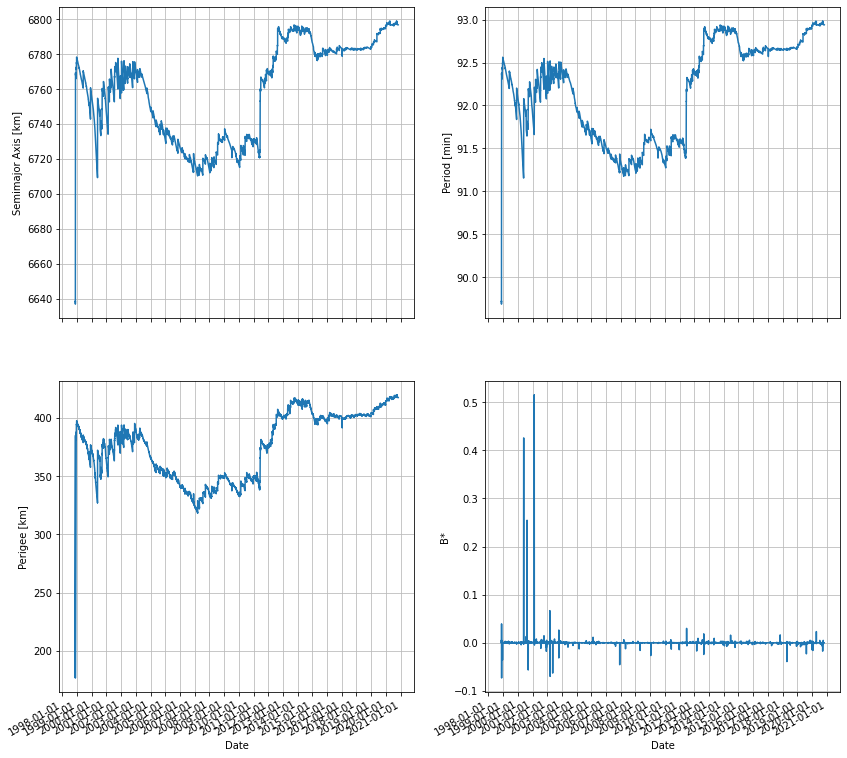

In [20]:
# 時間変化をプロット
fig = plt.figure(figsize=(14, 14))
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(df2['EPOCH2'], df2['SEMIMAJOR_AXIS'])
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Semimajor Axis [km]")
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(df2['EPOCH2'], df2['PERIOD'])
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax2.set_xlabel("Date")
ax2.set_ylabel("Period [min]")
ax2.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(df2['EPOCH2'], df2['PERIGEE'])
ax3.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax3.set_xlabel("Date")
ax3.set_ylabel("Perigee [km]")
ax3.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(df2['EPOCH2'], df2['BSTAR'])
ax4.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax4.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax4.set_xlabel("Date")
ax4.set_ylabel("B*")
ax4.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.show()